In [1]:
import graph_tool.all as gt
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import os


n=50; m=50; n_iter = 10*8; plt_scale = 7; density=0.65;
num_states = 2
N=n*m//10; print(N)
space_scale = 2.8
P=3; Q=2*P;
npr.RandomState(2)

DRAW = False #Dump drawn frames to disk?

250


In [2]:
def gen_ints(N, p, n=1):
    #n, p = 1, .5  number of trials, probability of each trial
    s = np.random.binomial(n, p, N)
    return s

In [3]:
def make_rpGA(dim, num_states, density=0.5):
    points = npr.random((N, 2))*space_scale
    g= gt.Graph(directed=False)
    g.vp.pos = g.new_vertex_property("vector<double>")
    g, g.vp.pos = gt.geometric_graph(points, 10 * space_scale / (n + m))
    g.gp.age = g.new_graph_property("int")

    g.vp.state = g.new_vertex_property("int")
    g.vp.color = g.new_vertex_property("string")
    g.ep.weight = g.new_edge_property("int")
    nedg = g.num_edges()
    g.ep.weight.a = np.array([1 for i in range(nedg)])
    
    states_vals=gen_ints(dim, density, n=1)
    #print(sum(states_vals))
    #print(g.list_properties())
    for i, v in enumerate(g.vertices()):
        g.gp.age = 0
        g.vp.state[v] = states_vals[i]
        if g.vp.state[v] == 0:
            g.vp.color[v] = "black"
        else:
            g.vp.color[v] = "white"
    return g



In [4]:
g = make_rpGA(N, num_states, density=density)

In [5]:
def update_state(g, v): #updates the state of a vertex with rules analogous to the original GoL

    Nv = g.get_all_neighbors(v)
    sum_nbstates = sum([g.vp.state[u] for u in Nv])
    nb_size = len(Nv)
    acoef = sum_nbstates/nb_size
    #print(acoef)
    if (g.vp.state[v]==1):
        if 2/nb_size<=acoef<=3/nb_size:
            g.vp.state[v]=1;
            g.vp.color[v] = "white"
        else:
            g.vp.state[v]=0
            g.vp.color[v] = "black"
        
    elif (g.vp.state[v]==0):
        #if (acoef == 3/nb_size):
        if 2/nb_size<=acoef<=4/nb_size:
            g.vp.state[v]=1
            g.vp.color[v] = "white"
        else:
            g.vp.state[v]=0
            g.vp.color[v] = "black"
    return g.vp.state[v], g.vp.color[v]

In [6]:
def update_configuration(g, rule): #applies the update_state function to each vertex
    G = g.copy()
    to_remove =[]
    for v in g.vertices():
        if len(g.get_all_edges(v)) == 0:
            to_remove.append(v)
        else:
            G.vp.state[v], G.vp.color[v] = rule(G, v)

    G.remove_vertex(to_remove)
    return G

In [7]:
def update_topology(g): #updates the graph topology, based on the dynamics i.e., the vertices states
    G = g.copy()
    for v in g.vertices():
        neighbors = g.get_all_neighbors(v)
        for u in neighbors:
            if g.vp.state[v] == g.vp.state[u]:
                
                e_ = G.edge(v, u, all_edges=True)
                
                if g.vp.state[v] == 1:
                    
                    for e in e_:
                        G.ep.weight[e] = min([G.ep.weight[e]+1,Q*G.gp.age])
                        
                elif g.vp.state[v] == 0:
                    for e in e_:

                        if G.ep.weight[e] < 1:
                            G.remove_edge(e)

                        else:
                            if npr.rand() < 0.2:
                                G.ep.weight[e] -= 1


    G.gp.age +=1
    return G

In [8]:
def make_gif(g, rule, n_iter=n_iter,  outname='def'):
    fname_prefix = os.path.join("./frames", outname)
    if DRAW == True:
        gt.graph_draw(g,pos=g.vp.pos,vertex_shape="circle", vertex_fill_color=g.vp.color,vertex_size=9, output_size=(plt_scale*n,plt_scale*m), output=fname_prefix+"_draw0000.png");
    
    Gs = [g]
    
    for i in range(1, n_iter+1):
        G = update_configuration(Gs[-1], rule=rule)
        #print(len(G.vp.state.a), len(Gs[-1].vp.state.a))
        msize = min([len(G.vp.state.a), len(Gs[-1].vp.state.a)])
    
        if np.all(G.vp.state.a[-msize:-1] == Gs[-1].vp.state.a[-msize:-1]):
            print('early convergence')
            return Gs
        else:
            G= update_topology(G)
            npos = gt.sfdp_layout(G, pos=G.vp.pos, eweight=G.ep.weight, max_iter=1, init_step=0.01, K=0.5)
            G.vp.pos = npos

        if DRAW == True:
            fname_prefix = os.path.join("./frames", outname)
            gt.graph_draw(G,pos=G.vp.pos,vertex_shape="circle", vertex_fill_color=G.vp.color,vertex_size=9, output_size=(plt_scale*n,plt_scale*m), output=fname_prefix+"_draw%04d.png"  %i);
        
        Gs.append(G)

    return Gs

In [9]:
rule = update_state

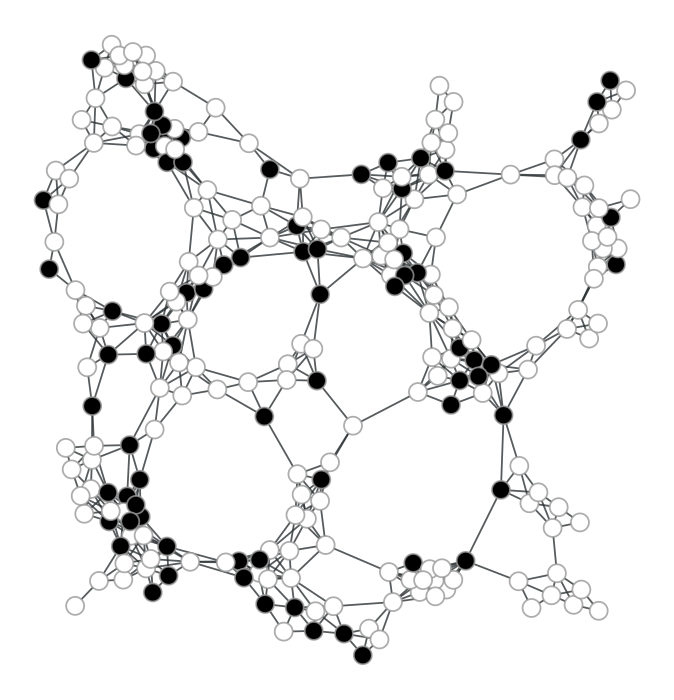

In [10]:
g = make_rpGA(N, num_states, density = density)
g.vp.pos = gt.sfdp_layout(g,pos=g.vp.pos, eweight=g.ep.weight,K=0.5)
gt.graph_draw(g,pos=g.vp.pos,vertex_shape="circle", vertex_fill_color=g.vp.color,vertex_size=9,output_size=(plt_scale*n,plt_scale*m));

In [11]:
if DRAW and not os.path.exists("./frames"):
    os.mkdir("./frames")

GS1 = make_gif(g,rule, n_iter=n_iter, outname='ga');

In [12]:
from ipywidgets import interact, interactive
from IPython import display

In [13]:
#gt.interactive_window(GS1[0], pos=GS1[0].vp.pos, vertex_fill_color=GS1[0].vp.color, update_layout=True, main=False)

In [14]:
def display_ga(ga_seq):
    def _show(gidx=(0, len(ga_seq)-1)):
        return gt.graph_draw(ga_seq[gidx],pos=ga_seq[gidx].vp.pos, vertex_fill_color=ga_seq[gidx].vp.color,vertex_size=9,output_size=(plt_scale*n,plt_scale*m), inline=True)
    return interact(_show)

In [15]:
display_ga(GS1)

interactive(children=(IntSlider(value=40, description='gidx', max=80), Output()), _dom_classes=('widget-intera…

<function __main__.display_ga.<locals>._show(gidx=(0, 80))>

In [16]:
def display_interactive_ga(ga_seq):   
    raise NotImplementedError
    gt.interactive_window(ga_seq[0], pos=ga_seq[0].vp.pos, vertex_fill_color=ga_seq[0].vp.color, update_layout=True, main=False, return_window=False)
    def _show(gidx=(0, len(ga_seq)-1)):
        return gt.interactive_window(ga_seq[gidx], pos=ga_seq[gidx].vp.pos, vertex_fill_color=ga_seq[gidx].vp.color, update_layout=True, main=False, window=gtwin, return_window=False)
    return interact(_show)
    
    